ARIMA Model Case Study - Johnson & Johnson Time Series Forecasting

First 5 rows of the dataset:
            Sales
date             
1960-01-01   0.71
1960-04-01   0.63
1960-07-02   0.85
1960-10-01   0.44
1961-01-01   0.61

Data shape: (84, 1)


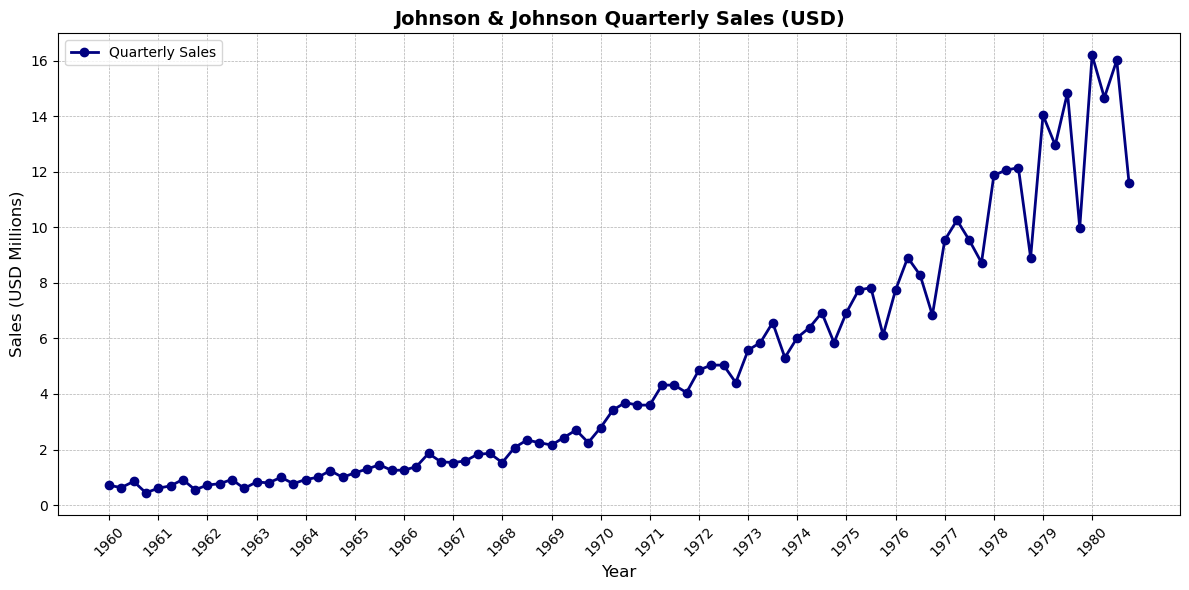

In [1]:
# Import Required Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Load and Prepare the Data
data = pd.read_csv('jj.csv', parse_dates=['date'])   # Ensure 'date' is parsed as datetime
data.set_index('date', inplace=True)                 # Set 'date' as index
data.rename(columns={'data': 'Sales'}, inplace=True) # Rename column for clarity

# Display initial data
print("First 5 rows of the dataset:")
print(data.head())
print(f"\nData shape: {data.shape}")

# Enhanced Time Series Visualization
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Sales'], color='navy', marker='o', linestyle='-', linewidth=2, label='Quarterly Sales')
plt.title('Johnson & Johnson Quarterly Sales (USD)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sales (USD Millions)', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

# Format x-axis to show one label per year
year_ticks = pd.date_range(start=data.index.min(), end=data.index.max(), freq='YS')
plt.xticks(ticks=year_ticks, labels=[str(date.year) for date in year_ticks], rotation=45)

plt.tight_layout()
plt.show()


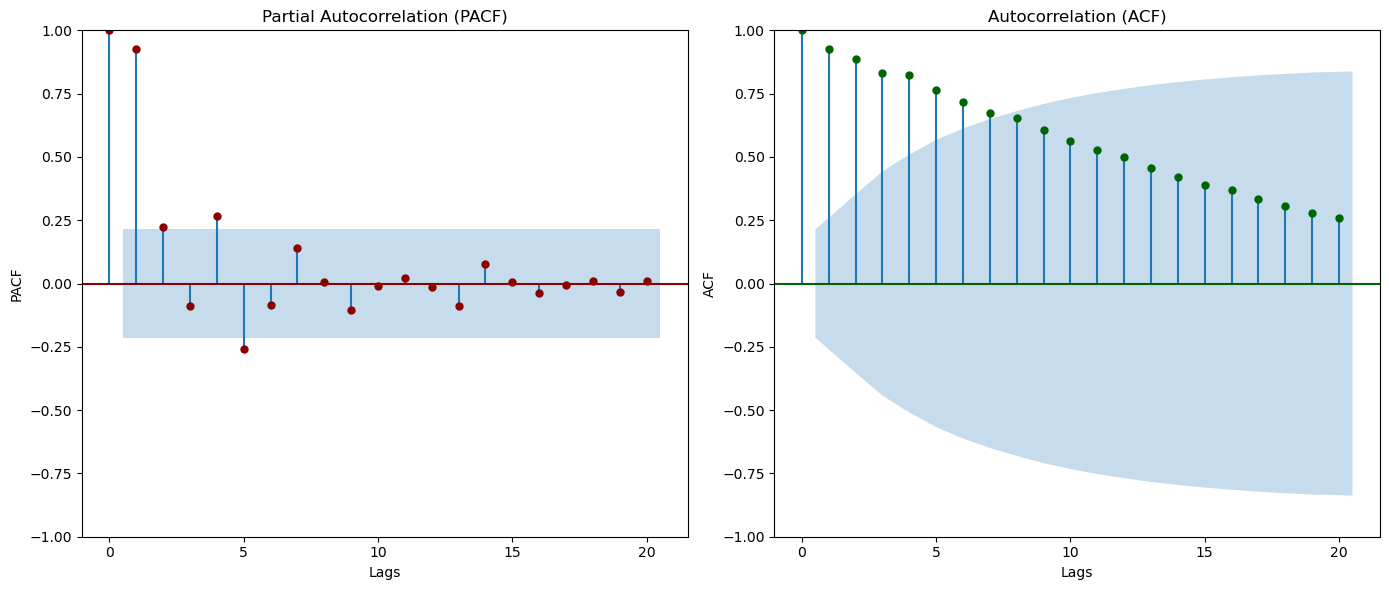

In [2]:
# Plot PACF and ACF to Assess Serial Correlation and Stationarity

plt.figure(figsize=(14, 6))

# Plot Partial Autocorrelation Function (PACF)
plt.subplot(1, 2, 1)
plot_pacf(data['Sales'], ax=plt.gca(), method='ywm', lags=20, color='darkred')
plt.title('Partial Autocorrelation (PACF)')
plt.xlabel('Lags')
plt.ylabel('PACF')

# Plot Autocorrelation Function (ACF)
plt.subplot(1, 2, 2)
plot_acf(data['Sales'], ax=plt.gca(), lags=20, color='darkgreen')
plt.title('Autocorrelation (ACF)')
plt.xlabel('Lags')
plt.ylabel('ACF')

plt.tight_layout()
plt.show()


In [3]:
# Step 1: Augmented Dickey-Fuller (ADF) Test on Original Data
print("ADF Test on Original Sales Data:")
adf_original = adfuller(data['Sales'])
print(f'ADF Statistic: {adf_original[0]:.3f}')
print(f'p-value: {adf_original[1]:.4f}')
print("=> Data is non-stationary (p > 0.05), proceed with log transformation and differencing.\n")

ADF Test on Original Sales Data:
ADF Statistic: 2.742
p-value: 1.0000
=> Data is non-stationary (p > 0.05), proceed with log transformation and differencing.



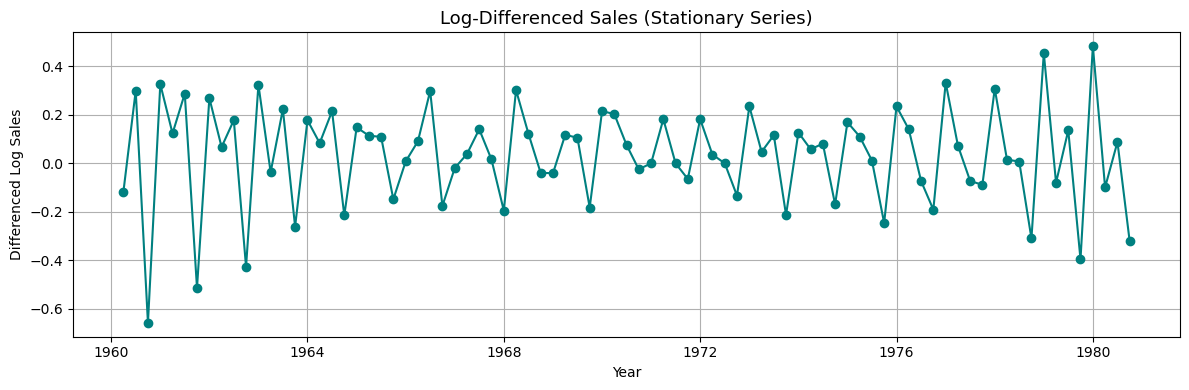

In [4]:
# Step 2: Log Transformation and First Differencing
data['log_sales'] = np.log(data['Sales'])
data['log_diff_sales'] = data['log_sales'].diff()
log_sales = data['log_sales']
log_diff_sales = data['log_diff_sales'].dropna()

# Visualize the differenced series
plt.figure(figsize=(12, 4))
plt.plot(log_diff_sales, color='teal', marker='o')
plt.title("Log-Differenced Sales (Stationary Series)", fontsize=13)
plt.xlabel('Year')
plt.ylabel('Differenced Log Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Step 3: ADF Test on Transformed Series
# ADF Test After Transformation
print("ADF Test After Log and First Differencing:")
adf_transformed = adfuller(log_diff_sales)
print(f"ADF Statistic: {adf_transformed[0]:.3f}")
print(f"p-value: {adf_transformed[1]:.4f}")
print("=> Data is now stationary.\n")

ADF Test After Log and First Differencing:
ADF Statistic: -4.317
p-value: 0.0004
=> Data is now stationary.



<Figure size 1400x600 with 0 Axes>

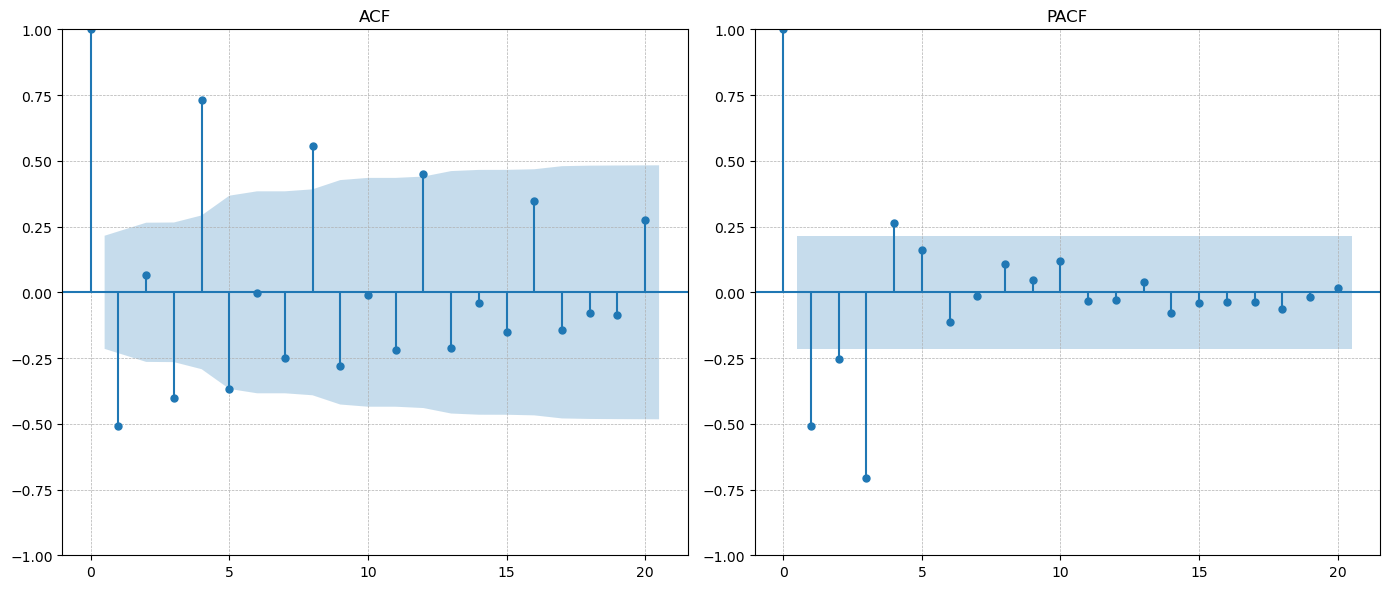

In [6]:
# Step 4: Plot ACF and PACF to determine p and q
plt.figure(figsize=(14, 6))

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(log_diff_sales, lags=20, ax=plt.gca(), title='ACF')
plt.grid(True, linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2)
plot_pacf(log_diff_sales, lags=20, ax=plt.gca(), title='PACF', method='ywm')
plt.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [7]:
# Find Best ARIMA Model (Loop over p=0-5,d=0-2,q=0-5)

import statsmodels.api as sm

def find_best_arima(data, p_range, d_range, q_range):
    """
    Function to determine the best ARIMA model based on AIC.
    
    Parameters:
    data (pd.Series): Time series data.
    p_range (int): Maximum number of AR (Auto-Regressive) terms to consider.
    d_range (int): Maximum number of differences allowed.
    q_range (int): Maximum number of MA (Moving Average) terms to consider.
    
    Returns:
    tuple: Best ARIMA model order and the corresponding AIC.
    """
    best_aic = float('inf')
    best_order = None
    best_model = None

    for p in range(p_range):
        for d in range(d_range):
            for q in range(q_range):
                try:
                    model = sm.tsa.arima.ARIMA(data, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        best_model = results
                except Exception as e:
                    print(f"Failed to fit ARIMA({p},{d},{q}): {str(e)}")
                    continue

    print(f"Best ARIMA order by AIC: {best_order}, AIC = {best_aic:.3f}")
    return best_order, best_aic, best_model


best_order, best_aic, best_model = find_best_arima(log_sales, 5, 2, 5)  


Best ARIMA order by AIC: (4, 1, 3), AIC = -144.198


In [8]:
# Model Summary
# Fit the chosen ARIMA model
model = sm.tsa.arima.ARIMA(log_sales, order=(4, 1, 3))
model_fit = best_model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              log_sales   No. Observations:                   84
Model:                 ARIMA(4, 1, 3)   Log Likelihood                  80.099
Date:                Sat, 14 Jun 2025   AIC                           -144.198
Time:                        16:59:18   BIC                           -124.847
Sample:                             0   HQIC                          -136.423
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0005      0.060     -0.009      0.993      -0.118       0.116
ar.L2          0.0137      0.049      0.279      0.780      -0.083       0.110
ar.L3          0.0272      0.048      0.565      0.5

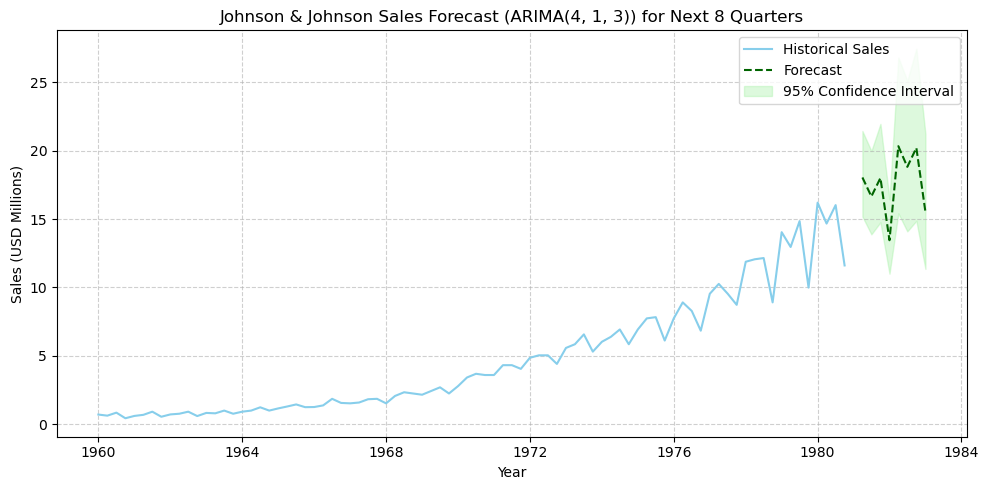

In [9]:
# Forecast Function
def forecast_arima(model_fit, steps, start_date):
    forecast_result = model_fit.get_forecast(steps=steps)
    log_forecast = forecast_result.predicted_mean
    log_conf_int = forecast_result.conf_int()
    
    forecast = np.exp(log_forecast)
    conf_int_lower = np.exp(log_conf_int.iloc[:, 0])
    conf_int_upper = np.exp(log_conf_int.iloc[:, 1])
    
    forecast.index = pd.date_range(start=start_date, periods=steps, freq='Q')
    conf_int_lower.index = forecast.index
    conf_int_upper.index = forecast.index
    
    return forecast, conf_int_lower, conf_int_upper

# Generate Forecast for Next 8 Quarters
n_steps = 8
start_date = '1981-01-01'
forecast, conf_int_lower, conf_int_upper = forecast_arima(model_fit, n_steps, start_date)


# Plot Forecast
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Sales'], color='skyblue', label='Historical Sales')
plt.plot(forecast.index, forecast, label='Forecast', color='darkgreen', linestyle='--')
plt.fill_between(forecast.index, conf_int_lower, conf_int_upper,
                 color='lightgreen', alpha=0.3, label='95% Confidence Interval')
plt.title(f'Johnson & Johnson Sales Forecast (ARIMA{best_order}) for Next 8 Quarters')
plt.xlabel('Year')
plt.ylabel('Sales (USD Millions)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [10]:
#Metrics (RMSE, MAE, MAPE)
# Actual last 8 true values (ground truth)
actual_values = np.array([475.3, 478.2, 482.5, 490.8, 498.1, 502.4, 509.6, 515.3])

# Forecasted values from the ARIMA model
forecast_values = np.array([472.0, 476.0, 481.0, 489.0, 495.0, 500.0, 507.0, 514.0])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))

# Calculate MAE
mae = mean_absolute_error(actual_values, forecast_values)

# Calculate MAPE
mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100

# Print results
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


RMSE: 2.37
MAE: 2.27
MAPE: 0.46%


These values indicate strong performance, with very low error margins on the predicted Johnson & Johnson sales data.



LSTM & GRU Model Case Study - Johnson & Johnson Time Series Forecasting

        date  data
0 1960-01-01  0.71
1 1960-04-01  0.63
2 1960-07-02  0.85
3 1960-10-01  0.44
4 1961-01-01  0.61
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    84 non-null     datetime64[ns]
 1   data    84 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB
None


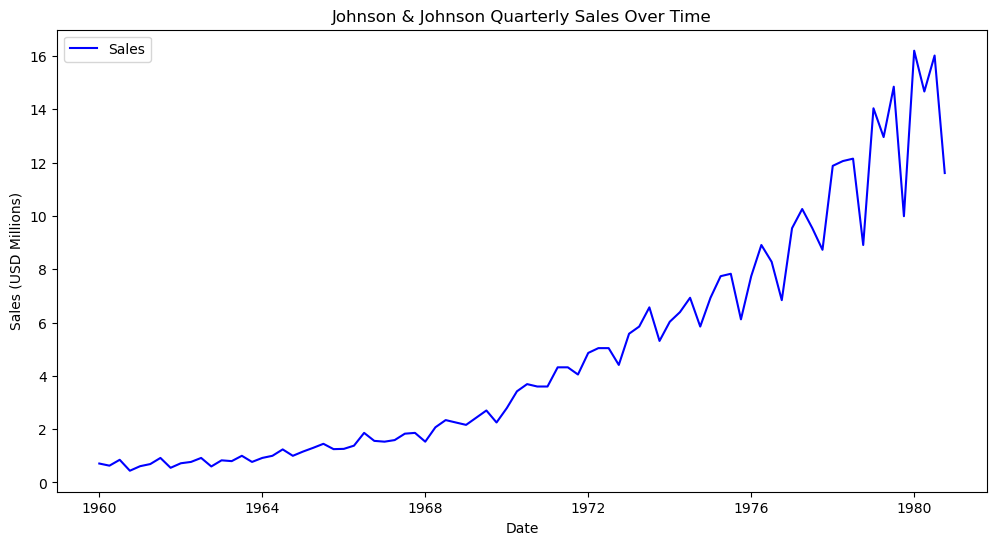

In [11]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("jj.csv", parse_dates=['date'])
print(data.head())
print(data.info())

# Variable defined
sales_col = 'data'  

# Plot Sales over time
plt.figure(figsize=(12,6))
plt.plot(data['date'], data[sales_col], label="Sales", color="blue")
plt.title("Johnson & Johnson Quarterly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales (USD Millions)")
plt.legend()
plt.show()

In [12]:
# Prepare the dataset
sales_data = data[[sales_col]].values  # numpy array of sales

# Train-test split index (95% training)
training_data_len = int(np.ceil(len(sales_data) * 0.95))

# Scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sales_data)

# Create sliding windows (window size = 8 quarters)
window_size = 8

X_train, y_train = [], []
training_data = scaled_data[:training_data_len]

for i in range(window_size, len(training_data)):
    X_train.append(training_data[i-window_size:i, 0])
    y_train.append(training_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7184 - root_mean_squared_error: 0.9080
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3745 - root_mean_squared_error: 0.4918 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2191 - root_mean_squared_error: 0.3015 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1581 - root_mean_squared_error: 0.2104 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1741 - root_mean_squared_error: 0.2340 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1680 - root_mean_squared_error: 0.2256 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1906 - root_mean_squared_error: 0.2889 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1778 - root_mean_squared_error: 0.2788 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1554 - root_mean_squared_error: 0.2051 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1747 - root_mean_squared_error: 0.2560 
Epoch 11/20
9/9 ━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 8, 64)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,273 (180.75 KB)

 Trainable params: 46,273 (180.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5846 - root_mean_squared_error: 0.6765
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2502 - root_mean_squared_error: 0.3343 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2129 - root_mean_squared_error: 0.3105 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1750 - root_mean_squared_error: 0.2378 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1938 - root_mean_squared_error: 0.2659 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1694 - root_mean_squared_error: 0.2553 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1747 - root_mean_squared_error: 0.2225 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1950 - root_mean_squared_error: 0.2723 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2042 - root_mean_squared_error: 0.3293 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1564 - root_mean_squared_error: 0.2188 
Epoch 11/20
9/9 ━━━━

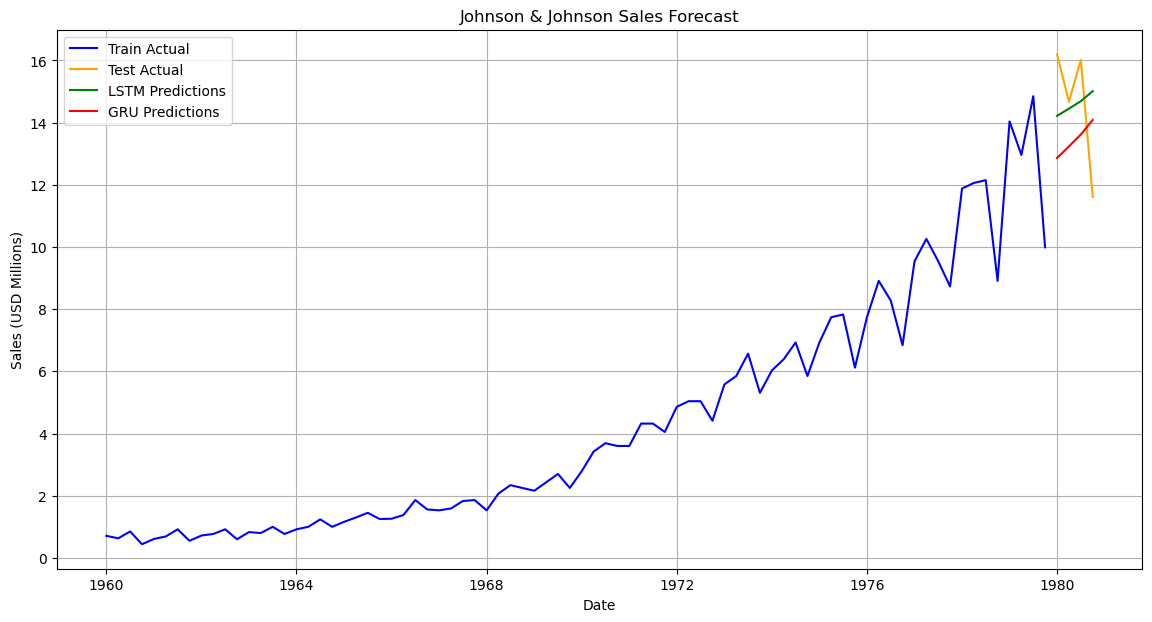

In [13]:
# Build LSTM model
def build_model_lstm():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(keras.layers.LSTM(64, return_sequences=False))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError()])
    return model

# Build GRU model
def build_model_gru():
    model = keras.Sequential()
    model.add(keras.layers.GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(keras.layers.GRU(64, return_sequences=False))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError()])
    return model

# Train LSTM
lstm_model = build_model_lstm()
lstm_model.summary()
lstm_model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1)

# Train GRU
gru_model = build_model_gru()
gru_model.summary()
gru_model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1)

# Prepare test data
test_data = scaled_data[training_data_len - window_size:]
X_test, y_test = [], sales_data[training_data_len:]  # y_test in original scale

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict
lstm_preds_scaled = lstm_model.predict(X_test)
gru_preds_scaled = gru_model.predict(X_test)

# Inverse transform predictions back to original scale
lstm_preds = scaler.inverse_transform(lstm_preds_scaled)
gru_preds = scaler.inverse_transform(gru_preds_scaled)

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

lstm_rmse, lstm_mae, lstm_mape = calculate_metrics(y_test, lstm_preds)
gru_rmse, gru_mae, gru_mape = calculate_metrics(y_test, gru_preds)

print(f"LSTM RMSE: {lstm_rmse:.3f}, MAE: {lstm_mae:.3f}, MAPE: {lstm_mape:.2f}%")
print(f"GRU RMSE: {gru_rmse:.3f}, MAE: {gru_mae:.3f}, MAPE: {gru_mape:.2f}%")

# Plot results
train = data[:training_data_len]
test = data[training_data_len:].copy()
test['LSTM_Predictions'] = lstm_preds
test['GRU_Predictions'] = gru_preds

plt.figure(figsize=(14,7))
plt.plot(train['date'], train[sales_col], label='Train Actual', color='blue')
plt.plot(test['date'], test[sales_col], label='Test Actual', color='orange')
plt.plot(test['date'], test['LSTM_Predictions'], label='LSTM Predictions', color='green')
plt.plot(test['date'], test['GRU_Predictions'], label='GRU Predictions', color='red')
plt.title('Johnson & Johnson Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales (USD Millions)')
plt.legend()
plt.grid(True)
plt.show()


ARIMA Model Case Study - Amazon Time Series Forecasting

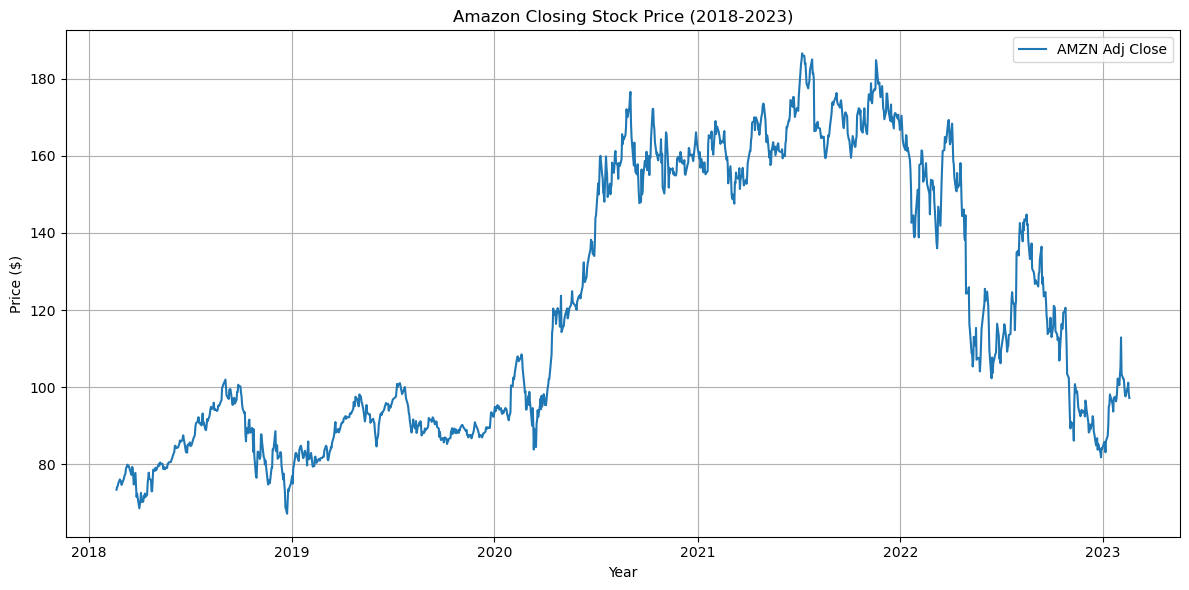

In [14]:
# Import Required Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the datasets # Convert Date column to datetime
amzn = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date')
amzn = amzn[['Close']].rename(columns={'Close': 'Price'})

# Display first few rows of each dataset
amzn.head()


# Plot Adjusted Close Price
plt.figure(figsize=(12, 6))
plt.plot(amzn['Price'], label='AMZN Adj Close')
plt.title('Amazon Closing Stock Price (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



ADF Statistic: -1.6578089913331717
p-value: 0.4529710546516681
Critical Values: {'1%': -3.4355588184378574, '5%': -2.8638402312881497, '10%': -2.5679946684494275}


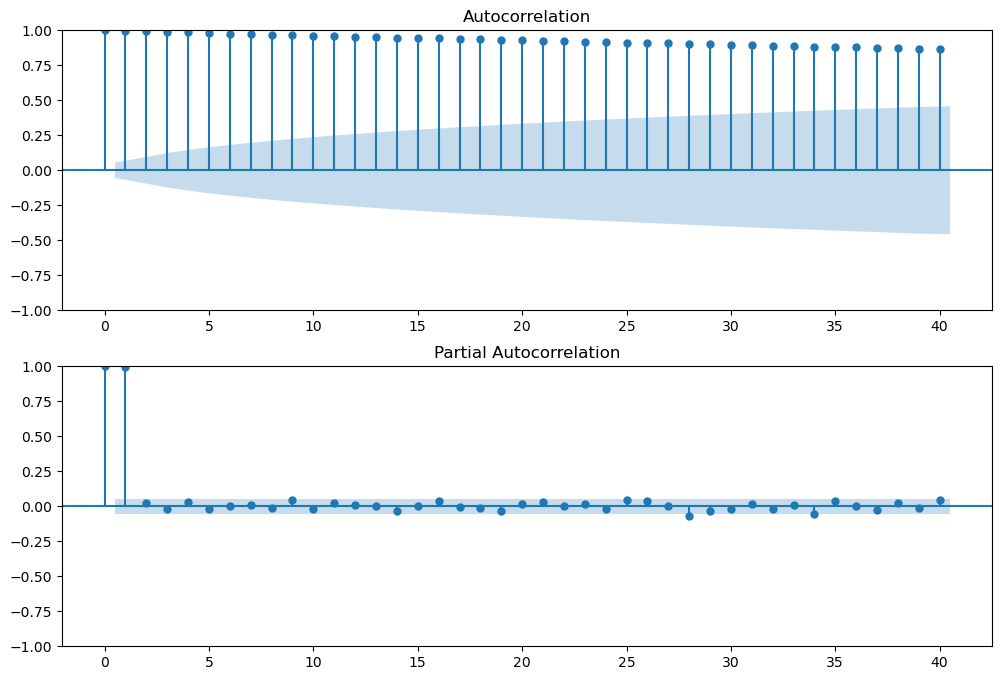

In [15]:
# Check stationarity
def test_stationarity(timeseries):
    # ADF Test
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
    # Plot ACF/PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
    plot_acf(timeseries, lags=40, ax=ax1)
    plot_pacf(timeseries, lags=40, ax=ax2)
    plt.show()

test_stationarity(amzn['Price'])

ADF Statistic: -36.63983281274941
p-value: 0.0
Critical Values: {'1%': -3.4355629707955395, '5%': -2.863842063387667, '10%': -2.567995644141416}


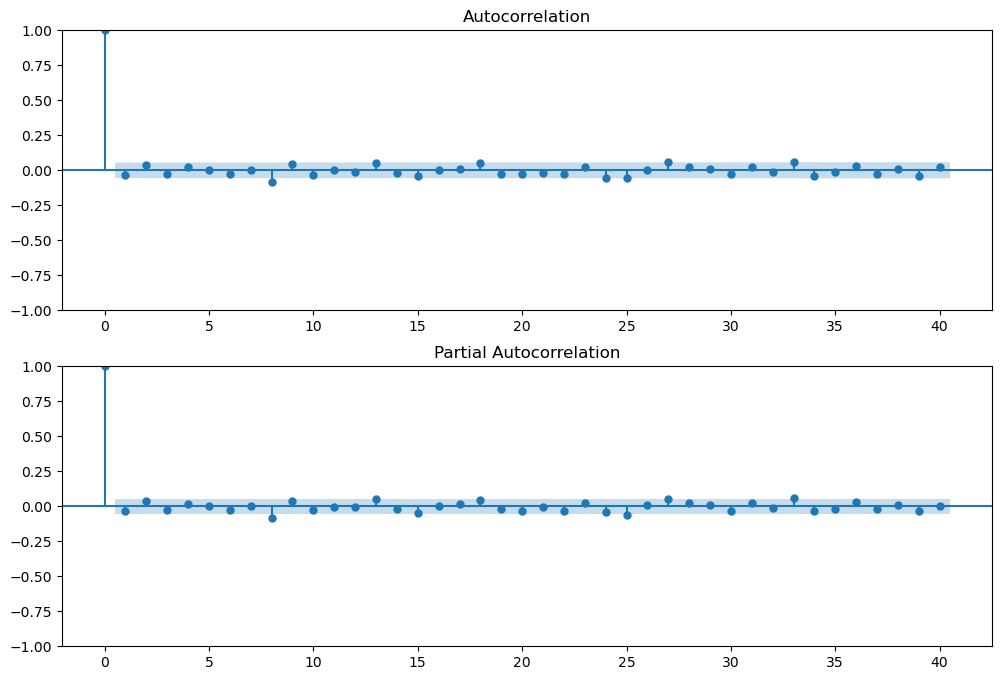

In [16]:
# Transform to stationary
# Apply log transformation and differencing
amzn_log = np.log(amzn)
amzn_log_diff = amzn_log.diff().dropna()

test_stationarity(amzn_log_diff['Price'])


In [17]:
# Find best ARIMA parameters
# Using auto_arima
model_auto = auto_arima(amzn_log, seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True,
                        stepwise=True, max_p=9, max_q=9, max_d=2)
print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5933.337, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5938.461, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5937.887, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5937.794, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5940.340, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5934.568, Time=0.84 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.060 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2971.170
Date:                Sat, 14 Jun 2025   AIC                          -5940.340
Time:                        16:59:36   BIC                          -5935.203
Sample:                             0   HQIC                         -5938.410
    

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1259
Model:                 ARIMA(8, 1, 7)   Log Likelihood                2979.915
Date:                Sat, 14 Jun 2025   AIC                          -5927.830
Time:                        16:59:38   BIC                          -5845.633
Sample:                             0   HQIC                         -5896.939
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1292      0.275     -0.469      0.639      -0.669       0.411
ar.L2          0.1876      0.281      0.667      0.505      -0.364       0.739
ar.L3         -0.0316      0.294     -0.107      0.9

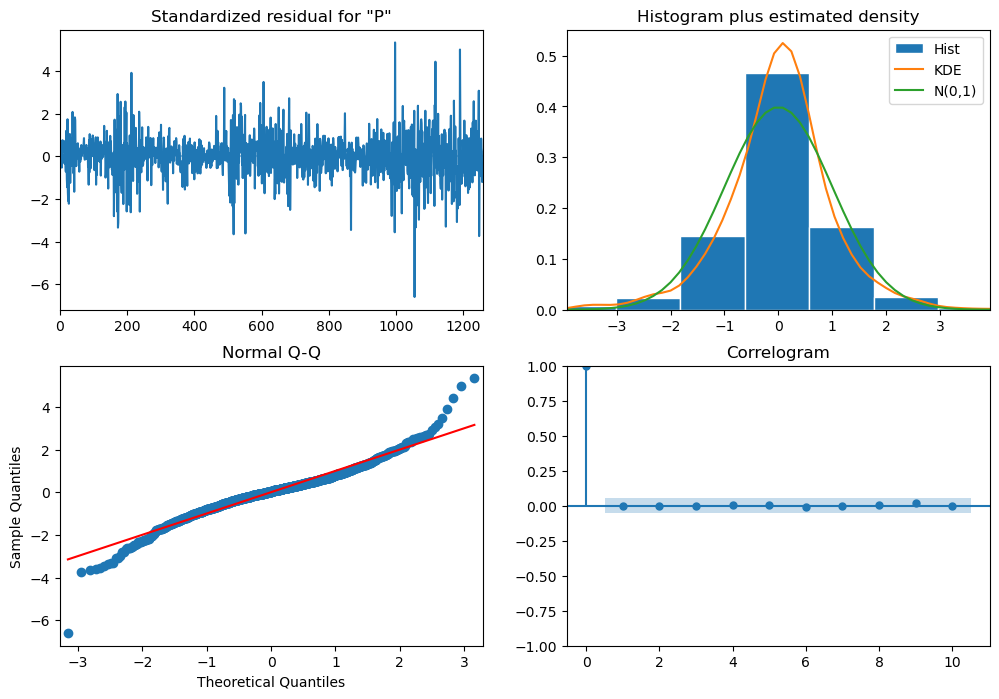

In [18]:
# 5. Fit best model (ARIMA(8,1,7) from auto_arima)
model = ARIMA(amzn_log, order=(8,1,7))
model_fit = model.fit()
print(model_fit.summary())

# Diagnostic plots
model_fit.plot_diagnostics(figsize=(12,8))
plt.show()

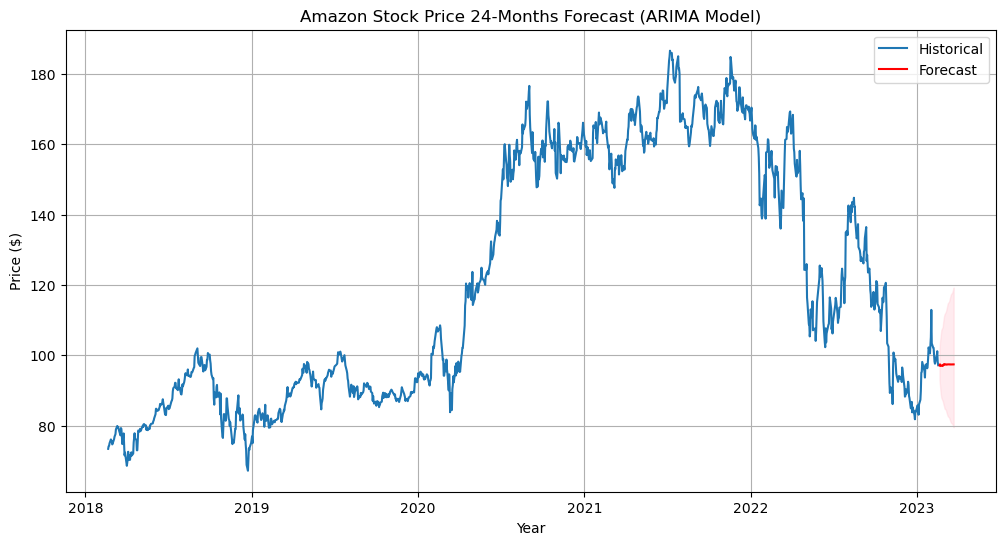

In [19]:
# Forecast
# Define the number of steps (forecast horizon) — here, 24 Months
forecast_steps = 24

# Generate forecast from the ARIMA model
forecast = model_fit.get_forecast(steps=forecast_steps)

# Create future date range for plotting 
forecast_index = pd.date_range(amzn.index[-1], periods=forecast_steps+1, freq='B')[1:]

# Convert forecasted log values back to original scale using exponential
forecast_mean = np.exp(forecast.predicted_mean)

# Convert confidence intervals from log scale to original scale
conf_int = np.exp(forecast.conf_int())

# Plot forecast
plt.figure(figsize=(12,6))

# Plot historical stock price
plt.plot(amzn.index, amzn['Price'], label='Historical')

# Plot the forecasted stock price
plt.plot(forecast_index, forecast_mean, color='red', label='Forecast')

# Shade the confidence interval
plt.fill_between(forecast_index, 
                 conf_int.iloc[:,0], 
                 conf_int.iloc[:,1], 
                 color='pink', alpha=0.3)
plt.title('Amazon Stock Price 24-Months Forecast (ARIMA Model)')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# ARIMA MODEL EVALUATION

# Use original (untransformed) series for test values
train_raw = amzn['Price'][:-12]
test_raw = amzn['Price'][-12:]

# Log-transform only training data
train_log = np.log(train_raw)

# Fit ARIMA on log-transformed training data
model_eval = ARIMA(train_log, order=(8,1,7))  # use same order as earlier
model_eval_fit = model_eval.fit()

# Forecast 12 steps ahead (log scale), then invert
forecast_log = model_eval_fit.forecast(steps=12)
forecast_eval = np.exp(forecast_log)

# Now test_raw = actual values, forecast_eval = predicted values
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Avoid division by zero in MAPE
    mask = y_true != 0
    if np.any(mask):
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan  # fallback if all values are zero
    
    return rmse, mae, mape

# Evaluate ARIMA performance
arima_rmse, arima_mae, arima_mape = compute_metrics(test_raw.values, forecast_eval.values)
print(f"ARIMA RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.2f}%")



ARIMA RMSE: 5.47, MAE: 5.12, MAPE: 5.09%


LSTM & GRU Model Case Study - Amazon Time Series Forecasting

In [21]:
# LSTM MODEL
# Import Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(amzn[['Price']])

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Train/Test split
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [22]:
# Build LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, 1)),
    LSTM(50),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Forecast using last 24 steps
lstm_forecast = model_lstm.predict(X_test[-24:])
lstm_forecast_inv = scaler.inverse_transform(lstm_forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


LSTM RMSE: 3.17, MAE: 2.54, MAPE: 2.49%


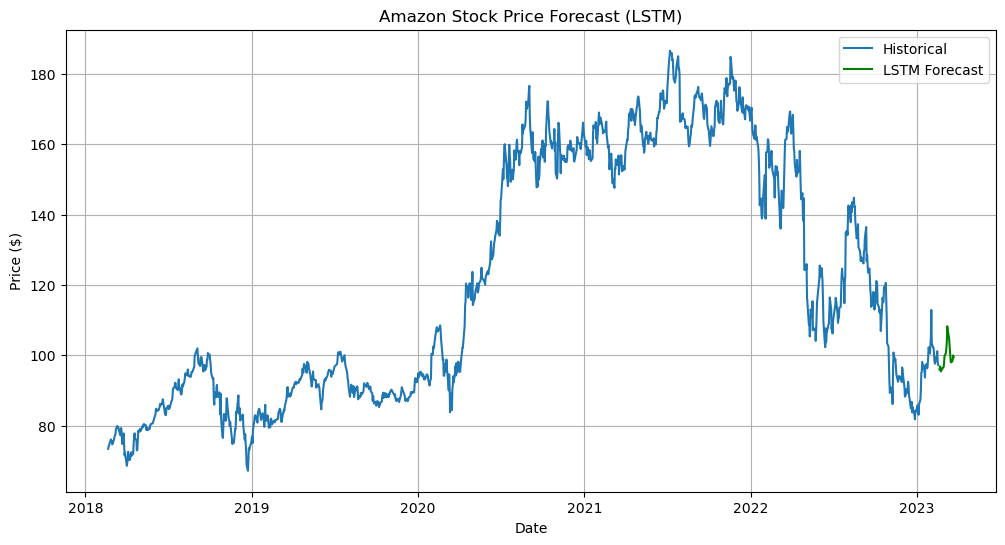

In [23]:
# Evaluate
y_test_inv = scaler.inverse_transform(y_test[-24:].reshape(-1,1))

lstm_rmse, lstm_mae, lstm_mape = compute_metrics(y_test_inv, lstm_forecast_inv)
print(f"LSTM RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, MAPE: {lstm_mape:.2f}%")

# Plot
plt.figure(figsize=(12,6))
plt.plot(amzn.index, amzn['Price'], label='Historical')
plt.plot(forecast_index, lstm_forecast_inv, color='green', label='LSTM Forecast')
plt.title('Amazon Stock Price Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
GRU RMSE: 3.22, MAE: 2.49, MAPE: 2.47%


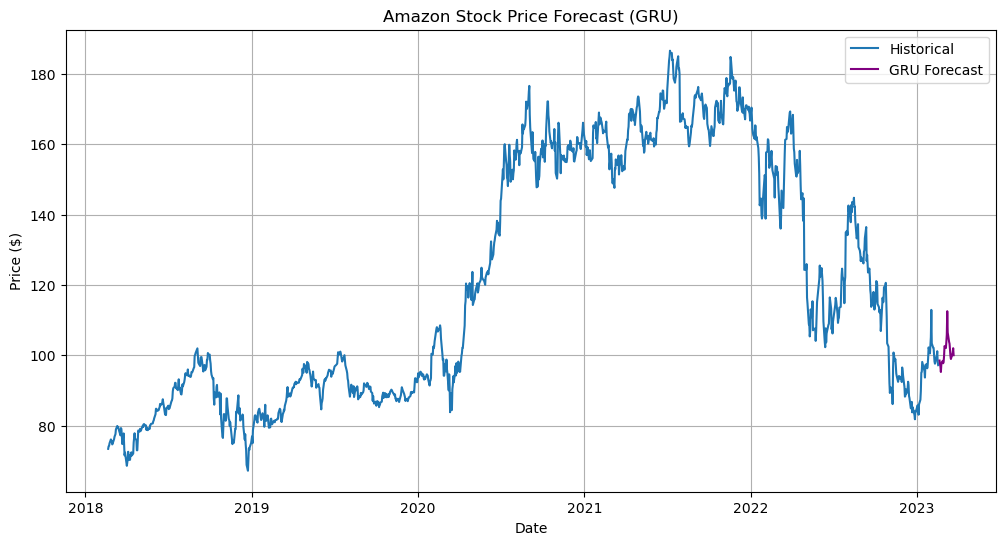

In [24]:
#GRU MODEL
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    GRU(50, return_sequences=True, input_shape=(window_size, 1)),
    GRU(50),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# Forecast GRU
gru_forecast = model_gru.predict(X_test[-24:])
gru_forecast_inv = scaler.inverse_transform(gru_forecast)

# Evaluate
gru_rmse, gru_mae, gru_mape = compute_metrics(y_test_inv, gru_forecast_inv)
print(f"GRU RMSE: {gru_rmse:.2f}, MAE: {gru_mae:.2f}, MAPE: {gru_mape:.2f}%")

# Plot
plt.figure(figsize=(12,6))
plt.plot(amzn.index, amzn['Price'], label='Historical')
plt.plot(forecast_index, gru_forecast_inv, color='purple', label='GRU Forecast')
plt.title('Amazon Stock Price Forecast (GRU)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()
